# Import required libraries
* SAS SWAT for communication with SAS Viya
* SAS DLPy to work with deep learning functionalities

In [1]:
from swat import CAS
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.lr_scheduler import *
from dlpy.splitting import two_way_split
import cv2

## Connect to SAS Viya Environment

In [3]:
s = CAS(host='localhost', port=5570, username='sas', password='saspw')

## Load Images and their labels - Visualize training data
This function creates a ready-to-train image table including all images and the corresponding object labels.

In [4]:
object_detection_targets = create_object_detection_table_no_xml(conn=s,
                                                                data_path='/data/notebooks/Face_Mask_Detection/training_images_augmented/',
                                                                annotation_path='/data/notebooks/Face_Mask_Detection/training_images_augmented/',
                                                                coord_type='yolo',
                                                                output='detTbl',
                                                                image_size=(416,416))
object_detection_targets.insert(0, '_nObjects_')

NOTE: Images are loaded.
NOTE: Images are processed.
labels are being processed
NOTE: Object detection table is successfully created.


In [6]:
s.CASTable('detTbl').head(10)

,idjoin,_image_,_Object0_,_Object1_,_Object2_,_Object3_,_Object4_,_Object5_,_Object6_,_Object7_,...,_Object12_height,_Object13_height,_Object14_height,_Object15_height,_Object16_height,_Object17_height,_Object18_height,_Object19_height,_Object20_height,_nObjects_
0,nomask_10_0_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,no_mask,no_mask,no_mask,mask,no_mask,no_mask,mask,no_mask,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
1,mask_290_15_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,mask_272_12_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,mask_160_17_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,no_mask,mask,mask,mask,no_mask,mask,no_mask,no_mask,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0
4,nomask_33_12_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,no_mask,no_mask,no_mask,no_mask,no_mask,no_mask,no_mask,no_mask,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
5,nomask_27_12_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,mask,mask,no_mask,mask,no_mask,no_mask,mask,no_mask,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
6,mask_290_4_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,mask,mask,mask,no_mask,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
7,nomask_93_15_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,no_mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
8,nomask_2_12_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,no_mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,mask_196_8_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,mask,,,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


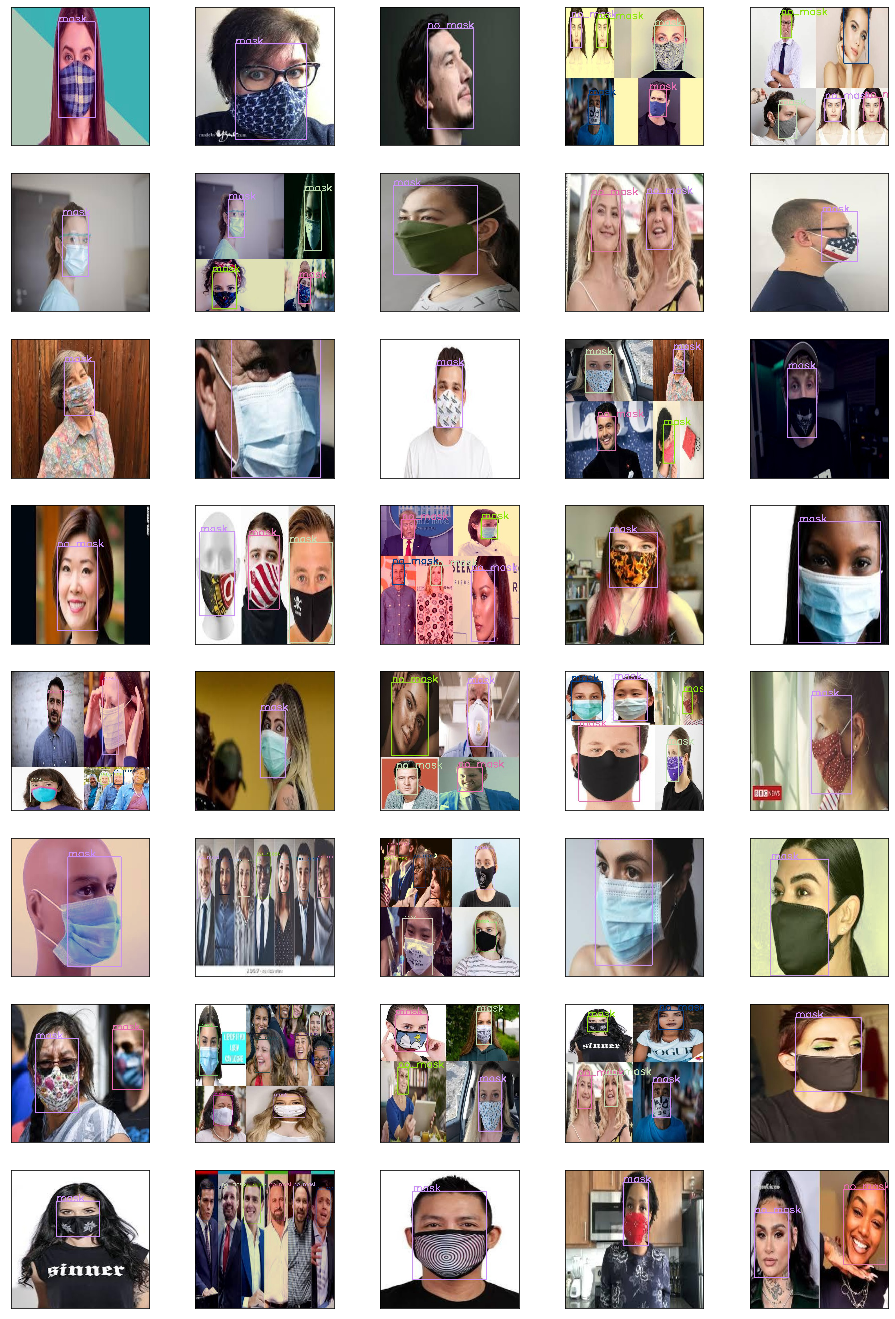

In [7]:
display_object_detections(conn=s, 
                          table=dict(name='detTbl', where='_nObjects_ > 0'), 
                          coord_type='yolo', 
                          max_objects=30, 
                          num_plot=40,
                          n_col=5)

## Split data into training and validation data

In [8]:
sampled_data = s.sampling.srs(table=dict(name='detTbl'), samppct=90, samppct2=10, partind=True, output=dict(casout=dict(name='sampled_data', replace=True), copyvars='all', partindname='Partind')).OutputCasTables['casTable'][0]
trainData = sampled_data[sampled_data['Partind'] == 1]
validData = sampled_data[sampled_data['Partind'] == 2]

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=879750801 for sampling.


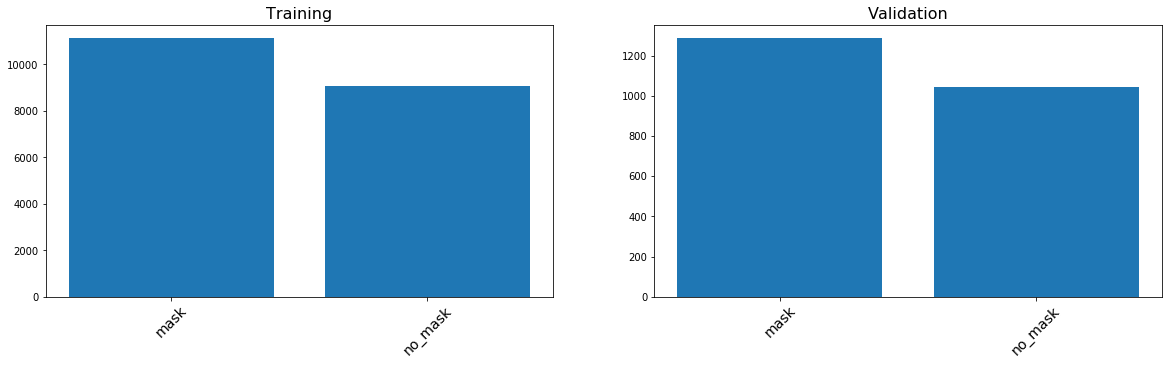

In [9]:
labels = list(get_info_for_object_detection(s, table=trainData)[0].keys())
object_info_train = get_info_for_object_detection(s, table=trainData)
object_info_val = get_info_for_object_detection(s, table=validData)
object_counts_train = [object_info_train[0][val] for val in object_info_train[0]]
object_counts_val = [object_info_val[0][val] for val in object_info_val[0]]

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20,5))
y_pos = np.arange(len(labels))
axes[0].set_title('Training', fontsize=16)
axes[0].bar(x=labels, height=object_counts_train)
axes[0].tick_params(axis="x", labelsize=14, rotation=45)
axes[1].set_title('Validation', fontsize=16)
axes[1].bar(x=labels, height=object_counts_val)
axes[1].tick_params(axis="x", labelsize=14, rotation=45)
plt.show()

In [10]:
get_info_for_object_detection(s, table=trainData), get_info_for_object_detection(s, table=validData)

(({'mask': 11137.0, 'no_mask': 9056.0}, 21),
 ({'mask': 1288.0, 'no_mask': 1045.0}, 16))

# Model Setup
### The following step will be performed to setup the YOLOv2 model:
1. Create Anchors for YOLOv2 model using KMeans-Clustering (optional: check visually if anchors capture object ratios)
2. Use pre-built YOLOv2 architecture with customized parameters (n_classes, n_anchors, predictions_per_grid, etc.)
3. Load pretrained weights
4. Define data_specs (model-inputs & model-target)
5. Define Learning-Rate scheduler, Solver and Optimizer
6. Start Training

In [11]:
yolo_anchors = get_anchors(conn=s, 
                           data=trainData, 
                           n_anchors=5, 
                           coord_type='yolo')
yolo_anchors

(2.8144683908045924,
 4.451566091954007,
 3.822520285394528,
 7.163813304420808,
 0.8171962095875134,
 1.6682831661092554,
 1.613463334416104,
 3.352165218450561,
 6.210740626920729,
 9.423632452366306)

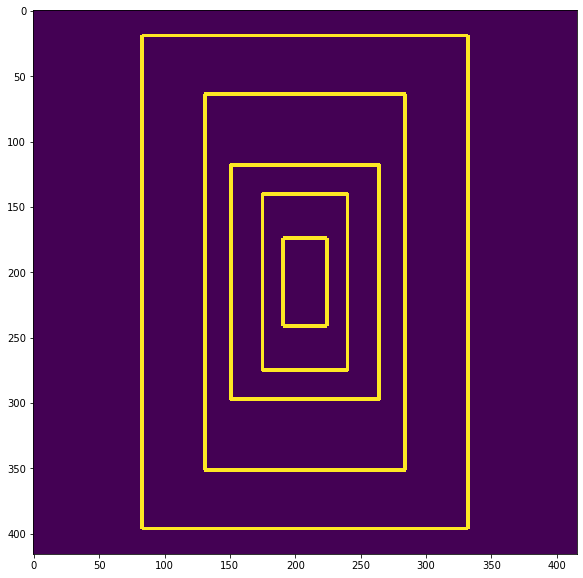

In [12]:
def plot_yolo_anchors(yolo_anchors, image_size, anchor_scale):
    anchor_image = np.zeros(image_size, np.int16)
    yolo_anchors = [yolo_anchors[ix:ix+2] for ix, _ in enumerate(yolo_anchors) if ix%2==0]
    x0,y0 = image_size[0]/2, image_size[1]/2
    for anchor in yolo_anchors:
        x1 = x0-anchor[0]/2*anchor_scale
        y1 = y0-anchor[1]/2*anchor_scale
        x2 = x0+anchor[0]/2*anchor_scale
        y2 = y0+anchor[1]/2*anchor_scale
        cv2.rectangle(anchor_image, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 2)
    plt.figure(figsize = (20,10))
    plt.imshow(anchor_image)
plot_yolo_anchors(yolo_anchors, image_size=(416,416), anchor_scale=40)

In [13]:
yolo_model = Tiny_YoloV2(conn=s, 
                         n_classes=2, 
                         predictions_per_grid=5, 
                         anchors = yolo_anchors,
                         max_boxes=100, 
                         coord_type='yolo',
                         max_label_per_image = 100,
                         class_scale=1.0, 
                         coord_scale=1.0, 
                         prediction_not_a_object_scale=1, 
                         object_scale=5,
                         detection_threshold=0.2, 
                         iou_threshold=0.2, 
                         width=416, 
                         height=416, 
                         grid_number=13, 
                         match_anchor_size=False)

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Detection layer added.
NOTE: Model compiled successfully.


In [23]:
yolo_model.summary

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,None,Input1,input,,,None,"(416, 416, 3)","(0, 0)",0
1,None,Convo.1,convo,"(3, 3)","(1, 1)",Identity,"(416, 416, 16)","(432, 0)",74760192
2,None,B.N.1,batchnorm,,,Leaky,"(416, 416, 16)","(0, 32)",0
3,None,Pool1,pool,"(2, 2)","(2, 2)",Max,"(208, 208, 16)","(0, 0)",0
4,None,Convo.2,convo,"(3, 3)","(1, 1)",Identity,"(208, 208, 32)","(4608, 0)",199360512
5,None,B.N.2,batchnorm,,,Leaky,"(208, 208, 32)","(0, 64)",0
6,None,Pool2,pool,"(2, 2)","(2, 2)",Max,"(104, 104, 32)","(0, 0)",0
7,None,Convo.3,convo,"(3, 3)","(1, 1)",Identity,"(104, 104, 64)","(18432, 0)",199360512
8,None,B.N.3,batchnorm,,,Leaky,"(104, 104, 64)","(0, 128)",0
9,None,Pool3,pool,"(2, 2)","(2, 2)",Max,"(52, 52, 64)","(0, 0)",0


In [14]:
data_specs = [DataSpec(type_='IMAGE', layer='Input1', data=['_image_']),
              DataSpec(type_='OBJECTDETECTION', layer='Detection1', data=object_detection_targets)]

In [15]:
lr_scheduler = ReduceLROnPlateau(conn=s, 
                                 cool_down_iters=5, 
                                 gamma=0.1, 
                                 learning_rate=0.001, 
                                 patience=5)
solver = MomentumSolver(momentum=0.9, 
                        lr_scheduler=lr_scheduler, 
                        clip_grad_max=100, 
                        clip_grad_min=-100)
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=1, 
                      log_level=2, 
                      max_epochs=80, 
                      reg_l2=0.0005,
                      stagnation=50)
gpu = Gpu(devices=[0])

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [16]:
# Start Training
yolo_model.fit(data=trainData,
               valid_table=validData,
               optimizer=optimizer,
               data_specs=data_specs, 
               n_threads=8, 
               record_seed=54321,
               force_equal_padding=True, 
               gpu=gpu,
               save_best_weights=True)

NOTE: Training from scratch.
NOTE: Using michael-AERO-15-X9: 1 out of 1 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 11031952.
NOTE:  The approximate memory cost is 508.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       5.27 (s).
NOTE:  The total number of threads on each worker is 8.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 8.
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: mask    
NOTE:  Level      1: no_mask 
NOTE:  Epoch Learning Rate        Loss        IOU  Validation Loss   Validation IOU   Time(s)
NOTE:  0         0.001           12.91     0.6772            13.77           0.6666    47.28
NOTE:  1         0.001           4.913      0.758            5.571           0.7553    48.08
NOTE:  2         0.001          

,Descr,Value
0,Model Name,tiny-yolov2
1,Model Type,Convolutional Neural Network
2,Number of Layers,25
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,9
6,Number of Pooling Layers,6
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,8
9,Number of Detection Layers,1


## Verify Model Training
Validation Loss should decrease over time. If Validation Loss increases - the model might be overfitting the data.<br>
Additionally we can score our validation images with the trained model and visually verify the correctness of its predictions for some images.<br>
In the last step we plot some object-detection measures, e.g. mean average percentage.

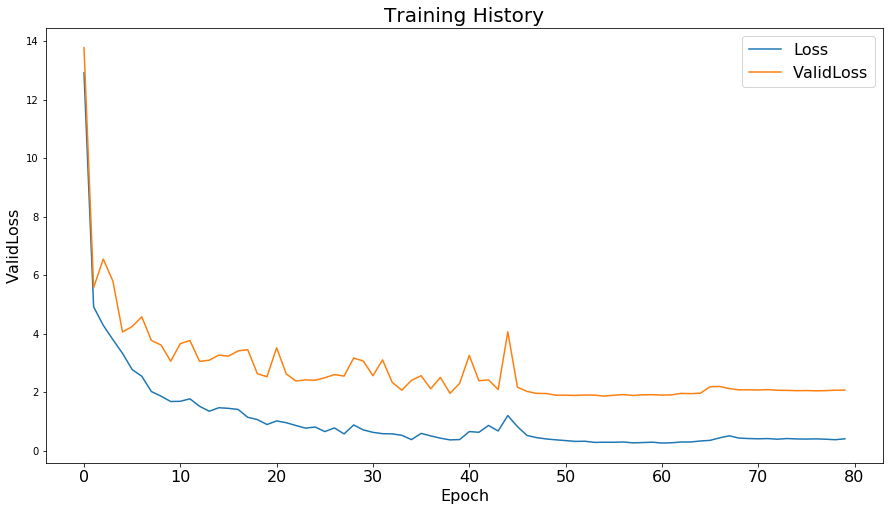

In [17]:
plt.figure(figsize = (15,8))
plt.plot(yolo_model.training_history.tail(100)[['Loss','ValidLoss']])
plt.ylabel('ValidLoss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.xticks(fontsize=16)
plt.title('Training History', fontsize=20)
plt.legend(['Loss','ValidLoss'], fontsize=16)
plt.show()

### Set Model weights to the best weights achieved during training and score test data

In [18]:
yolo_model.set_weights(yolo_model.best_weights)

NOTE: Model weights attached successfully!


In [19]:
yolo_model.predict(data=validData, gpu=gpu)

NOTE: Using michael-AERO-15-X9: 1 out of 1 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           898
 1  Number of Observations Used           898
 2     Average IoU in Detection      0.915553
 3                   Loss Error      6.471908

[OutputCasTables]

          casLib              Name  Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_U2XNpb   898     5075   
 
                                             casTable  
 0  CASTable('Valid_Res_U2XNpb', caslib='CASUSER(s...  

+ Elapsed: 4.89s, user: 10.3s, sys: 0.401s, mem: 563mb

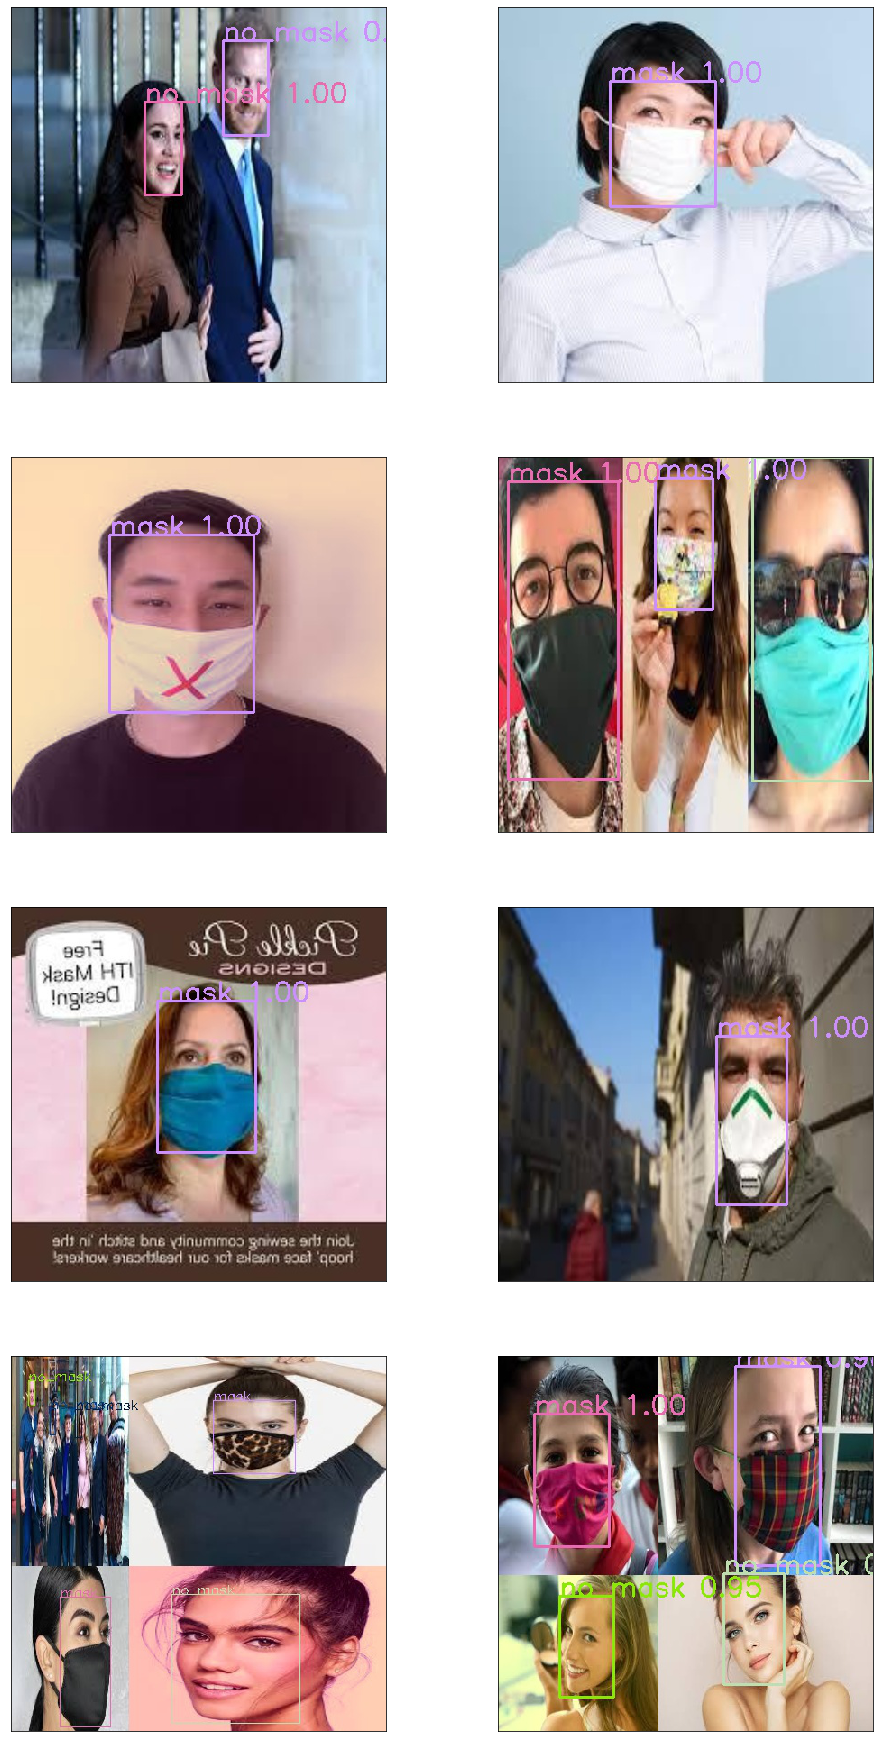

In [20]:
display_object_detections(conn=s, 
                          table=yolo_model.valid_res_tbl, 
                          coord_type='yolo', 
                          max_objects=100, 
                          num_plot=8,
                          n_col=2)

In [21]:
yolo_model.valid_res_tbl.head(20)

,idjoin,_image_,Partind,_eq_1_,_nObjects_,_Object0_,_P_Object0_,_Object0_x,_Object0_y,_Object0_width,...,_Object843_x,_Object843_y,_Object843_width,_Object843_height,_Object844_,_P_Object844_,_Object844_x,_Object844_y,_Object844_width,_Object844_height
0,mask_133_6_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,1.0,1.0,mask,0.999750,0.607757,0.468806,0.554352,...,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN
1,mask_224_2_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,1.0,1.0,mask,0.999649,0.588537,0.632160,0.345182,...,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN
2,nomask_85_12_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,1.0,2.0,no_mask,0.998148,0.118509,0.521311,0.213523,...,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN
3,mask_103_3_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,1.0,11.0,no_mask,0.999491,0.377205,0.330238,0.370312,...,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN
4,nomask_59_7_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,1.0,4.0,no_mask,0.985658,0.757732,0.216607,0.272055,...,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN
5,nomask_148_9_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,1.0,8.0,no_mask,0.999430,0.185525,0.157539,0.170639,...,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN
6,mask_213_13_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,1.0,1.0,mask,0.999381,0.556275,0.443508,0.541172,...,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN
7,mask_241_16_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,1.0,5.0,mask,0.997328,0.855445,0.364953,0.149328,...,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN
8,mask_169_8_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,1.0,1.0,mask,0.999924,0.322648,0.467358,0.494927,...,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN
9,mask_232_12_mosaic_hflip_hsv,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2.0,1.0,1.0,mask,0.999790,0.463488,0.422553,0.167918,...,NaN,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN


### Deploy model as Astore file for further scoring in applications (e.g. SAS Event Stream Processing)

In [22]:
yolo_model.save_to_astore('/data/notebooks/Face_Mask_Detection/')

NOTE: Model astore file saved successfully.


In [ ]:
yolo_model.save_weights_csv('/data/notebooks/Face_Mask_Detection/')